In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl


## Final

Using device: cuda


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Filter:   0%|          | 0/120000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/119959 [00:00<?, ? examples/s]

Map:   0%|          | 0/7598 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 980,740 || all params: 125,629,448 || trainable%: 0.7807


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-2-9b3b3a771b8f>:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.229400,0.209905,0.931693
2,0.191400,0.182718,0.939721
3,0.174900,0.166929,0.944327
4,0.159300,0.170730,0.947223
5,0.146200,0.167328,0.946038
6,0.141000,0.161601,0.948013
7,0.130100,0.163143,0.948276
8,0.124700,0.164040,0.948407


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

Final Evaluation Accuracy: 0.9484074756514872


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Final Evaluation Accuracy: 0.9484074756514872
Trainable parameters: 980740


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

✅ Batched predictions complete. Saved to submission.csv.


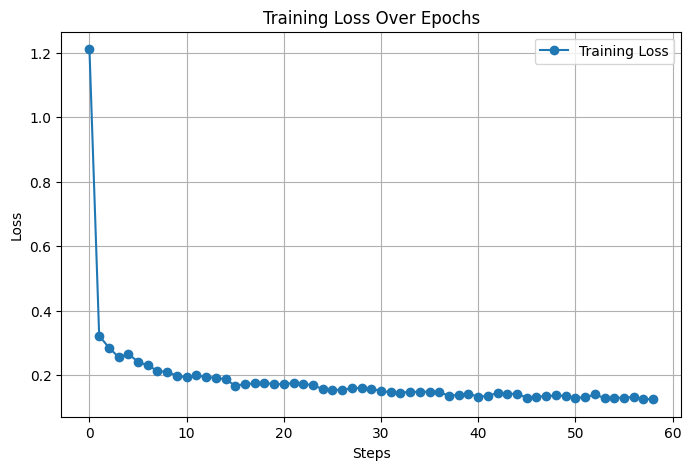

In [2]:


# -----------------------------
# 1. Import libraries
# -----------------------------
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback
from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import pickle

# -----------------------------
# 2. Use GPU if available
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------
# 3. Load and preprocess AGNEWS dataset
# -----------------------------
dataset = load_dataset("ag_news")
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def filter_dataset(example):
    length = len(example["text"].split())
    return 3 < length < 128  # drop very short or too long

dataset = dataset.filter(filter_dataset)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])




# -----------------------------
# 4. Load RoBERTa model with LoRA adapters
# -----------------------------
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

lora_config = LoraConfig(
    r=7,
    lora_alpha=32,
    target_modules=["query", "value", "key"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(model, lora_config)
model.to(device)
model.print_trainable_parameters()

# -----------------------------
# 5. Define training arguments
# -----------------------------
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",  # Save checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=8,
    weight_decay=0.01,
    warmup_ratio=0.1,  # warmup 10%
    lr_scheduler_type="cosine_with_restarts",  # cosine annealing
    logging_dir="./logs",
    report_to="none",
    optim="adamw_torch"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}


# -----------------------------
# 6. Train the model
# -----------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    seed=42
)

trainer.train()

# -----------------------------
# 7. Evaluate the model
# -----------------------------
eval_results = trainer.evaluate()
print("Final Evaluation Accuracy:", eval_results["eval_accuracy"])

# -----------------------------
# 7. Evaluate the model
# -----------------------------
eval_results = trainer.evaluate()
print("Final Evaluation Accuracy:", eval_results["eval_accuracy"])
# -----------------------------
# 8. Check trainable parameter count
# -----------------------------
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

from datasets import Dataset
from torch.utils.data import DataLoader

# Load dataset object
with open("/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl", "rb") as f:
    test_dataset = pickle.load(f)

# Convert to HuggingFace Dataset (already is, but this helps formatting)
test_dataset = Dataset.from_dict({"text": test_dataset["text"]})

# Tokenize function
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Apply tokenizer
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Create PyTorch DataLoader for batching
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=64)

# Prediction loop
model.eval()
all_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_predictions.extend(preds.cpu().numpy())


# -----------------------------
# 10. Save predictions to CSV
# -----------------------------
df = pd.DataFrame({
    "ID": list(range(len(all_predictions))),   # ID ✅
    "label": all_predictions
})
df.to_csv("submission3.csv", index=False)
print("✅ Batched predictions complete. Saved to submission.csv.")

train_loss_log = [log["loss"] for log in trainer.state.log_history if "loss" in log]

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_loss_log, marker='o', label="Training Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.savefig("train_loss_curve.png")
plt.show()